In [1]:
import os
import numpy as np
import sklearn as sk
import h5py
import analyze_tools as at
at.log.set_level("debug")

In [2]:
def get_count_trajectory(fname, cache_fname=None):
    if cache_fname and os.path.exists(cache_fname):
        return np.load(cache_fname)
    else:
        dtraj = []
        if os.path.exists(fname):
            with h5py.File(fname) as f:
                traj = f["readdy/trajectory"]
                traj_time = traj["time"]
                traj_time_records = traj["records"]
                for time, records in zip(traj_time, traj_time_records):
                    current_counts = [0]*4
                    for record in records:
                        type_id = record["typeId"]
                        current_counts[type_id] += 1
                    dtraj.append(current_counts)
        else:
            log.warn("file {} did not exist".format(fname))
        dtraj = np.array(dtraj)
        if cache_fname:
            np.save(cache_fname, dtraj)
        return dtraj
def get_count_trajectory_n_particles_obs(fname, cache_fname=None):
    with h5py.File(fname) as f:
        return f["readdy/observables/n_particles/data"][:].astype(np.double)

In [3]:
counts = get_count_trajectory_n_particles_obs("../generate/simple_trajectory_.h5", cache_fname='counts_traj_2.npy')
counts = counts[:45*500]
n_timesteps = counts.shape[0]

In [4]:
time_step = .01
dcounts_dt = np.gradient(counts, axis=0) / time_step
print(counts.shape)
print("max counts = {}, min counts = {}".format(np.max(counts), np.min(counts[np.nonzero(counts)])))

(22500, 4)
max counts = 6000.0, min counts = 1.0


# mean field model

In [5]:
theta1 = lambda x: x[:,0]
theta2 = lambda x: x[:,1]
theta3 = lambda x: x[:,2]
theta4 = lambda x: x[:,0]*x[:,1]
theta5 = lambda x: x[:,0]*x[:,2]
theta6 = lambda x: x[:,1]*x[:,2]

In [7]:
theta = np.array([theta1(counts), theta2(counts), theta3(counts), theta4(counts), theta5(counts), theta6(counts)])

In [8]:
# theta in R^(species x ansatz functions * n_timesteps)
print(theta.shape)

(6, 22500)


In [9]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=1, positive=True)
clf.fit(theta.T, dcounts_dt)

/home/mho/miniconda2/envs/readdy_dev/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=True, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [10]:
print(dcounts_dt.shape)
print(theta.shape)

(22500, 4)
(6, 22500)


In [11]:
print(clf.coef_)

[[  0.00000000e+00   0.00000000e+00   3.64252109e-04   0.00000000e+00
    0.00000000e+00   3.69458475e-08]
 [  0.00000000e+00   0.00000000e+00   1.28981969e-04   0.00000000e+00
    0.00000000e+00   3.89371597e-08]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.91796602e-08
    1.86586066e-09   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.95457237e-08
    1.00287058e-08   7.51698880e-09]]


# Simon way (solve for all times indepdenently, use markov property)

In [12]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=15, warm_start=False, max_iter=1000, tol=1e-6, positive=True)

In [13]:
theta1 = lambda x: np.array([-x[0]*x[1], -x[0]*x[1], x[0]*x[1], 0])
theta2 = lambda x: np.array([x[2], x[2], -x[2], 0])
theta3 = lambda x: np.array([-x[0], x[0], 0, 0])
theta5 = lambda x: np.array([-x[0], 0, 0, x[0]])

In [15]:
alphas = []
for i in range(0, n_timesteps):
    c = counts[i]
    theta = np.array([theta1(c), theta2(c), theta3(c), theta5(c)])
    dc = dcounts_dt[i]
    clf.fit(theta.T, dc)
    alphas.append(clf.coef_)

In [16]:
xi = np.sum(alphas, axis=0) / len(alphas)
print("xi = %s" % xi)

xi = [  1.70342302e-06   0.00000000e+00   0.00000000e+00   1.03512901e-02]


In [17]:
from scipy.integrate import odeint

In [18]:
def fun(data, _):
    theta = np.array([theta1(data), theta2(data), theta3(data), theta5(data)])
    return np.matmul(xi, theta)

In [19]:
num_solution = odeint(fun, counts[0], np.arange(0, n_timesteps*.01, .01))

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

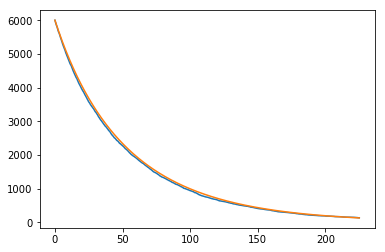

In [21]:
plt.plot(np.arange(0, n_timesteps*.01, .01), counts[:,0])
plt.plot(np.arange(0, n_timesteps*.01, .01), num_solution[:, 0])

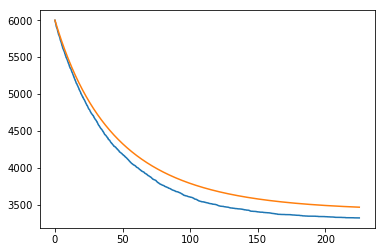

In [22]:
plt.plot(np.arange(0, n_timesteps * .01, .01), counts[:,1])
plt.plot(np.arange(0, n_timesteps * .01, .01), num_solution[:, 1])

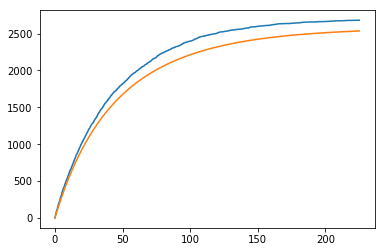

In [23]:
plt.plot(np.arange(0, n_timesteps * .01, .01), counts[:,2])
plt.plot(np.arange(0, n_timesteps * .01, .01), num_solution[:, 2])

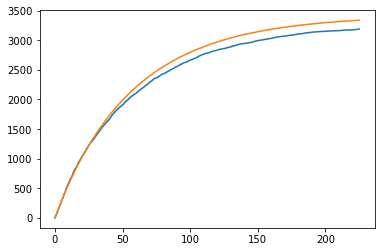

In [24]:
plt.plot(np.arange(0, n_timesteps * .01, .01), counts[:,3])
plt.plot(np.arange(0, n_timesteps * .01, .01), num_solution[:, 3])

In [25]:
diffusion_coeff = 0.2 
micro_rate = 0.05
reaction_radius = 0.7
tmp = np.sqrt(micro_rate / diffusion_coeff) * reaction_radius
rate_chapman = 4. * np.pi * diffusion_coeff * reaction_radius * (1. - np.tanh(tmp) / tmp)

In [26]:
print("erban chapman rate (per volume): {}".format(rate_chapman))
print("lasso fitted rate (per counts): {}".format(xi[0]))
print("lasso fitted rate (per volume): {}".format(xi[0] * 15 * 15 * 15))

erban chapman rate (per volume): 0.06848398371542153
lasso fitted rate (per counts): 1.703423022972958e-06
lasso fitted rate (per volume): 0.005749052702533734


### Objective function is sum over all timesteps and species + l1 penalty

In [27]:
import scipy.optimize as so
%matplotlib inline
import matplotlib.pyplot as plt

In [28]:
print(counts.shape)
n_timesteps = counts.shape[0]

(22500, 4)


In [18]:
theta1 = lambda x: np.array([-x[0]*x[1], -x[0]*x[1], x[0]*x[1], 0]) / (4.*n_timesteps)
theta2 = lambda x: np.array([x[2], x[2], -x[2], 0]) / (4.*n_timesteps)
theta3 = lambda x: np.array([-x[0], x[0], 0, 0]) / (4.*n_timesteps)
theta4 = lambda x: np.array([-x[0], 0, 0, x[0]]) / (4.*n_timesteps)

In [19]:
dc = dcounts_dt / (4.*n_timesteps)
cnts = counts
def objective_fun(alpha, k_reg, counts=cnts, dcounts_dt=dc, theta=[theta1, theta2, theta3, theta4]):
    n_timesteps = counts.shape[0]
    n_species = counts.shape[1]
    n_reactions = 4
    result = 0.
    for t_idx in range(n_timesteps):
        for s_idx in range(n_species):
            reaction_term = 0.
            for r_idx in range(n_reactions):
                #print("t s r", t_idx, s_idx, r_idx)
                reaction_term += theta[r_idx](counts[t_idx])[s_idx] * alpha[r_idx]
            result += (dcounts_dt[t_idx, s_idx] - reaction_term) * (dcounts_dt[t_idx, s_idx] - reaction_term)
    regularization = 0.
    for r_idx in range(n_reactions):
        regularization += k_reg * abs(alpha[r_idx])
    return result + regularization

In [20]:
init_xi = np.array([0.1,0.1,0.1,0.1])
objective_fun(init_xi, 10000000.)

12463883.206688292

In [32]:
bounds = ((0., None), (0., None), (0., None), (0., None))
result = so.minimize(
    lambda x: objective_fun(x, 10000000.), 
    init_xi,
    bounds=bounds, 
    callback=lambda x: print(x))

[  0.1  21.1   0.1   0.1]
[ 0.          0.          0.09999999  0.09995491]
[ 0.          0.00828154  0.09999999  0.09995491]
[ 0.          0.00898156  0.09999996  0.09995488]
[ 0.          0.00910013  0.09999937  0.09995434]
[ 0.          0.00967981  0.099993    0.09994851]
[ 0.          0.0105161   0.09997535  0.09993235]
[ 0.          0.01192354  0.09992284  0.09988426]
[ 0.          0.01415269  0.09978046  0.09975388]
[ 0.          0.01774286  0.09939509  0.09940098]
[ 0.          0.0233973   0.09837837  0.09846993]
[ 0.          0.03205838  0.09573987  0.09605374]
[ 0.          0.04426377  0.08915894  0.09002733]
[ 0.          0.02556437  0.07601122  0.07798742]
[ 0.          0.          0.00452816  0.01252751]
[  1.96116300e-06   0.00000000e+00   3.98521390e-03   1.10254130e-02]
[  2.01189180e-06   0.00000000e+00   1.38033702e-03   8.64011572e-03]
[  2.02863626e-06   0.00000000e+00   1.22956393e-03   8.67040312e-03]
[  2.04335034e-06   4.58405336e-05   6.25151117e-04   9.08731906

In [33]:
print(result)
print(result.x)
xi = result.x

      fun: 71306446.904473275
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([  4.90945941e+08,  -6.10053539e+03,   6.58568591e+06,
         1.78176165e+05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 195
      nit: 25
   status: 0
  success: True
        x: array([  1.92708641e-06,   7.02381627e-05,   0.00000000e+00,
         1.02073519e-02])
[  1.92708641e-06   7.02381627e-05   0.00000000e+00   1.02073519e-02]


In [34]:
from scipy.integrate import odeint

def fun(data, _):
    theta = np.array([theta1(data), theta2(data), theta3(data), theta4(data)])
    return np.matmul(xi, theta)

num_solution = odeint(fun, counts[0], np.arange(0, n_timesteps*.01, .01))

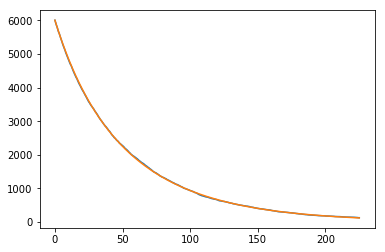

In [35]:
plt.plot(np.arange(0, n_timesteps*.01, .01), counts[:,0])
plt.plot(np.arange(0, n_timesteps*.01, .01), num_solution[:, 0])

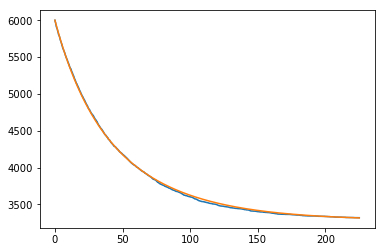

In [36]:
plt.plot(np.arange(0, n_timesteps * .01, .01), counts[:,1])
plt.plot(np.arange(0, n_timesteps * .01, .01), num_solution[:, 1])

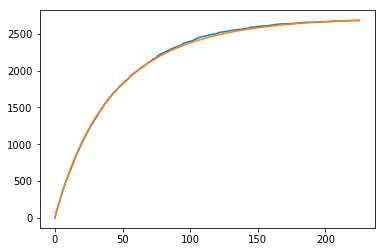

In [37]:
plt.plot(np.arange(0, n_timesteps * .01, .01), counts[:,2])
plt.plot(np.arange(0, n_timesteps * .01, .01), num_solution[:, 2])

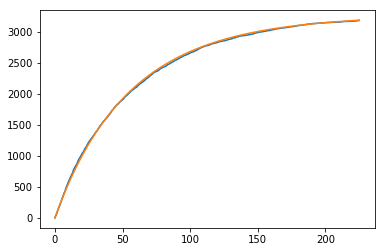

In [38]:
plt.plot(np.arange(0, n_timesteps * .01, .01), counts[:,3])
plt.plot(np.arange(0, n_timesteps * .01, .01), num_solution[:, 3])

# Sequential thresholded least squares 

In [24]:
theta1 = lambda x: np.array([-x[:,0]*x[:,1], -x[:,0]*x[:,1], x[:,0]*x[:,1], np.zeros(n_timesteps)])
theta2 = lambda x: np.array([x[:,2], x[:,2], -x[:,2], np.zeros(n_timesteps)])
theta3 = lambda x: np.array([-x[:,0], x[:,0], np.zeros(n_timesteps), np.zeros(n_timesteps)])
theta4 = lambda x: np.array([-x[:,0], np.zeros(n_timesteps), np.zeros(n_timesteps), x[:,0]])
theta5 = lambda x: np.array([x[:,3], np.zeros(n_timesteps), np.zeros(n_timesteps), -x[:,3]])

theta1_ode = lambda x: np.array([-x[0]*x[1], -x[0]*x[1], x[0]*x[1], 0])
theta2_ode = lambda x: np.array([x[2], x[2], -x[2], 0])
theta3_ode = lambda x: np.array([-x[0], x[0], 0, 0])
theta4_ode = lambda x: np.array([-x[0], 0, 0, x[0]])
theta5_ode = lambda x: np.array([x[3], 0, 0, -x[3]])

In [30]:
large_theta = np.array([theta1(counts), theta2(counts), theta3(counts), theta4(counts)])
large_theta = np.transpose(large_theta, axes=((2, 0, 1)))
print(np.sum(large_theta))
at.lasso_minimizer_objective_fun

-141003783889.0


<function analyze_tools.PyCapsule.lasso_minimizer_objective_fun>

In [31]:
large_theta.shape

(22500, 4, 4)

In [40]:
import scipy.optimize as so

bounds = ((0., None), (0., None), (0., None), (0., None))
init_xi = np.array([.1] * large_theta.shape[1])
result = so.minimize(
    lambda x: at.lasso_minimizer_objective_fun(x, .001, large_theta/(4.*n_timesteps), dcounts_dt/(4.*n_timesteps)), 
    init_xi,
    bounds=bounds, 
    callback=lambda x: print(x), tol=1e-16)
xi = result.x

[  0.09985031  21.1          0.09985031   0.09985031]
[ 0.          0.          0.10008319  0.10005228]
[ 0.          0.00945884  0.10008312  0.10005221]
[ 0.          0.00899849  0.1000831   0.10005219]
[ 0.          0.00882094  0.10008249  0.10005164]
[ 0.          0.00851937  0.10007987  0.10004923]
[ 0.          0.00777213  0.10006779  0.10003817]
[ 0.          0.00671868  0.10003738  0.10001032]
[ 0.          0.00491756  0.09994919  0.09992956]
[ 0.          0.00206027  0.09971598  0.09971597]
[ 0.          0.          0.09909231  0.0991448 ]
[ 0.          0.          0.08344723  0.08481657]
[ 0.          0.          0.00226568  0.01046811]
[  2.00973834e-06   0.00000000e+00   1.90597463e-03   8.98556976e-03]
[  2.02044683e-06   1.45460263e-05   1.43425862e-03   8.55988531e-03]
[  2.03271957e-06   1.88012965e-04   1.40707314e-03   8.60136671e-03]
[  2.01914884e-06   1.39864261e-04   1.20972145e-03   8.73214563e-03]
[  1.92907456e-06   2.13982113e-05   0.00000000e+00   1.00567281e-

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

from scipy.integrate import odeint

def fun(data, _):
    theta = np.array([theta1_ode(data), theta2_ode(data), theta3_ode(data), theta4_ode(data)])
    return np.matmul(xi, theta)

num_solution = odeint(fun, counts[0], np.arange(0, n_timesteps*.01, .01))

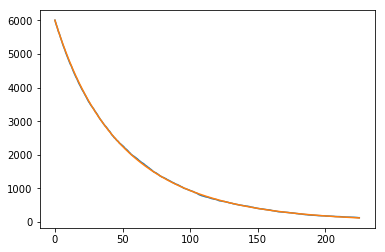

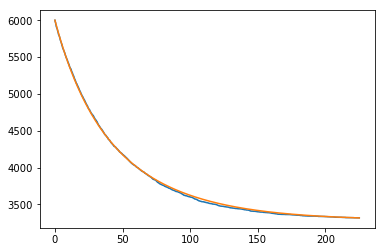

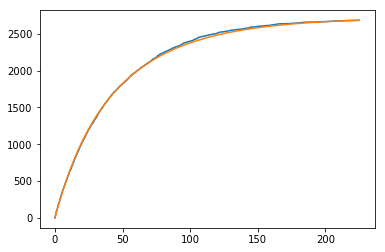

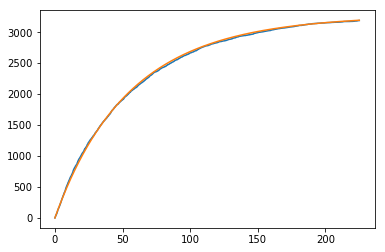

In [42]:
for i in range(4):
    plt.plot(np.arange(0, n_timesteps*.01, .01), counts[:,i])
    plt.plot(np.arange(0, n_timesteps*.01, .01), num_solution[:, i])
    plt.show()
